In [1]:
import numpy as np
import os
import pickle
import pprint as pp
import matplotlib.pyplot as plt
from heapq import nsmallest


In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300

In [3]:
def getDataFromFile(filename):
    with open(filename, 'rb') as f:
        x = pickle.load(f)
        print(f'Retreived Data from {filename}')
        return x
def getDataFromDatFile(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            item = line.rstrip()
            data.append(item)
        return data
def writeDataToFile(data, filename):
    outfile = open(filename,'wb')
    pickle.dump(data,outfile)
    outfile.close()
    print(f'wrote data to {filename}')


In [4]:
def getMinimums(data, windowSize, k=0):
    ret = []
    if k == 0:
        for i in range(0, len(data)-windowSize, windowSize):
            ret.append(np.min(data[i:i+windowSize]))
    else: 
        ret = getKthMinimums(data, windowSize, k)
    return ret
def getKthMinimums(data, windowSize, k):
    ret = []
    for i in range(0, len(data)-windowSize, windowSize):
        a = sorted(data[i:i+windowSize])
        ret.append(a[k])
    return ret
def twoWindow(data, windowSize=16, jump1=80, short=False):
    if len(data)/2 < windowSize:
        print(f'too little data {len(data)} to run twoWindow with window size {windowSize}')
        return 0, [], []
    jumps = []
    flag = 0
    mins = getMinimums(data, windowSize)
    for i in range(len(mins) - 1):
        if mins[i+1] - mins[i] >= jump1:
            jumps.append(i)
            flag = 1
            if short:
                return flag, mins, jumps
    return flag, mins, jumps 
def threeWindow(data, windowSize=16, jump1=80, jump2=2, short=False):
    if len(data)/3 < windowSize:
        print(f'too little data {len(data)} to run threeWindow with window size {windowSize}')
        return 0, [], [], []
    jumps = [] # index of jumps
    bloats = []
    flag = 0 # 0: nothing, 1: contains an suspected attack
    mins = getMinimums(data, windowSize)
    for i in range(len(mins) - 2):
        if mins[i+1] - mins[i] >= jump1:
            ## see a jump, is it bloat or sustained?
            if abs(mins[i+2] - mins[i+1]) < jump2:
                jumps.append(i)
                flag = 0
                if short:
                    return flag, mins, jumps, bloats
            else:
                bloats.append(i)
    return flag, mins, jumps, bloats
def threeWindowKthMin(data, windowSize=16, jump1=80, jump2=2, k=1, short=False):
    if len(data)/3 < windowSize:
        print(f'too little data {len(data)} to run threeWindow with window size {windowSize}')
        return 0, [], [], []
    jumps = [] # index of jumps
    bloats = []
    flag = 0 # 0: nothing, 1: contains an suspected attack
    mins = getMinimums(data, windowSize, k=k)
    for i in range(len(mins) - 2):
        if mins[i+1] - mins[i] >= jump1:
            ## see a jump, is it bloat or sustained?
            if abs(mins[i+2] - mins[i+1]) < jump2:
                jumps.append(i)
                flag = 0
                if short:
                    return flag, mins, jumps, bloats
            else:
                bloats.append(i)
    return flag, mins, jumps, bloats

In [5]:
def prepareDataForPlot(filename):
    data = getDataFromFile(filename)
    y = [x.split(" ")[1] for x in data]
    return y
def plotPeeringDataForThreeWindow(data, windowSize, jump1, jump2, k=0, file="", title=""):
    fig, ax = plt.subplots()
    flag, mins, jumps, bloats= threeWindowKthMin(data, windowSize,jump1,jump2,k=k)
    jumpsY = [y[j] for j in jumps]
    jumps = [j * windowSize for j in jumps]
    minsX = [i * windowSize for i in range(len(mins))]
    plt.plot(data, 'x')
    plt.plot(jumps, jumpsY, 'ro', markerSize=12)
    plt.plot(minsX, mins, '*-', LineWidth=0.5)
    plt.xlabel("sample", FontSize=12)
    plt.ylabel("RTT (ms)", FontSize=12)
    plt.title(title)
    if file!="":
        plt.savefig(file)
    return len(jumps)
    
def plotPeeringDataForTwoWindow(data, windowSize, jump1, file="", title=""):
    flag, mins, jumps= twoWindow(data, windowSize,jump1)
    jumpsY = [y[j] for j in jumps]
    jumps = [j * windowSize for j in jumps]
    minsX = [i * windowSize for i in range(len(mins))]
    plotFigure(data, minsX, mins, jumps, jumpsY, file, title )
    return len(jumps)

def plotFigure(data, minsX, mins, jumps, jumpsY, file, title=""):
    fig, ax = plt.subplots()
    plt.plot(data, 'x')
    plt.plot(jumps, jumpsY, 'ro', markerSize=12)
    plt.plot(minsX, mins, '*-', LineWidth=0.5)
    plt.xlabel("sample", FontSize=13)
    plt.ylabel("RTT (ms)", FontSize=13)
    if file!="":
        plt.savefig(file)
    plt.title(title)
    

In [176]:
def checkThreeWindow(y):
    count = 0
    badCount = 0
    goodCount = 0
    goodParameters = []
    badParameters = []
    for windowSize  in [4, 8,16,24,32,48]:
        for jump1 in [5,10,20,30,40,50,75, 100, 125, 200]:
            for jump2 in [2,5,9]:
                count+=1

                flag, mins, jumps,_ = threeWindow(y, windowSize, jump1, jump2)
                if len(jumps) < 1:
    #                 if badCount<1:
#                     plotPeeringDataForThreeWindow(y, windowSize, jump1, jump2, file=f'./PEERINGPresentationFigure-{windowSize}-{jump1}-{jump2}.png', title=f'{windowSize}, {jump1}, {jump2}')
                    badCount+=1
                    badParameters.append((windowSize,jump1,jump2))


                else:
    #                 if goodCount < 1:
    #                     plotPeeringDataForThreeWindow(y, windowSize, jump1, jump2, file=f'./PEERINGPresentationFigure-{windowSize}-{jump1}-{jump2}.png',title=f'{windowSize}, {jump1}, {jump2}')
                    goodCount += 1
                    goodParameters.append((windowSize, jump1, jump2))
    return [goodParameters, badParameters]
    # plotPeeringDataForTwoWindow(y, windowSize, jump1, file=f'/n/fs/scratch/djubas/neu-ireland-{windowSize}-{jump1}.png')

In [175]:
# takes in data and checks it against two window algorithm with all parameter options. If has anything
# other than one jump it is considered bad, otherwise considered good. 
# returns list of goodParameters and badParameters where each item in list is (<windowsize>, <jump value>)
def checkTwoWindow(y):
    count = 0
    badCount = 0
    goodCount = 0
    goodParameters = []
    badParameters = []

    for windowSize  in [4, 8,16,24,48]:
        for jump1 in [5, 10, 20,30,40,50,75,100, 125, 200]:

            count+=1

            flag, mins, jumps = twoWindow(y, windowSize, jump1)
            if len(jumps) < 1:
#                 plotPeeringDataForTwoWindow(y, windowSize, jump1, title=f'{windowSize}, {jump1}')
                badCount+=1
                badParameters.append((windowSize, jump1))    


            else:
    #             if goodCount < 1:
    #                 plotPeeringDataForTwoWindow(y, windowSize, jump1, title=f'{windowSize}, {jump1}, {jump2}')
                goodCount += 1
                goodParameters.append((windowSize, jump1))
    return [goodParameters, badParameters]
# plotPeeringDataForTwoWindow(y, windowSize, jump1, file=f'/n/fs/scratch/djubas/neu-ireland-{windowSize}-{jump1}.png')

<DirEntry 'neu-ireland-6.dat'>
<DirEntry 'neu-ireland-rtts-4.dat'>
<DirEntry 'neu-ireland-8.dat'>
<DirEntry 'neu-ireland-rtts-3.dat'>
<DirEntry 'neu-ireland-7.dat'>
<DirEntry 'wisc-seattle-3.dat'>
<DirEntry 'wisc-seattle-1.dat.txt'>
<DirEntry 'wisc-seattle-2.dat'>
<DirEntry 'neu-pton-5.dat'>
<DirEntry 'neu-pton-2.dat'>
<DirEntry 'neu-pton-good-2.dat'>
<DirEntry 'neu-pton-6.dat'>
<DirEntry 'neu-pton-4.dat'>


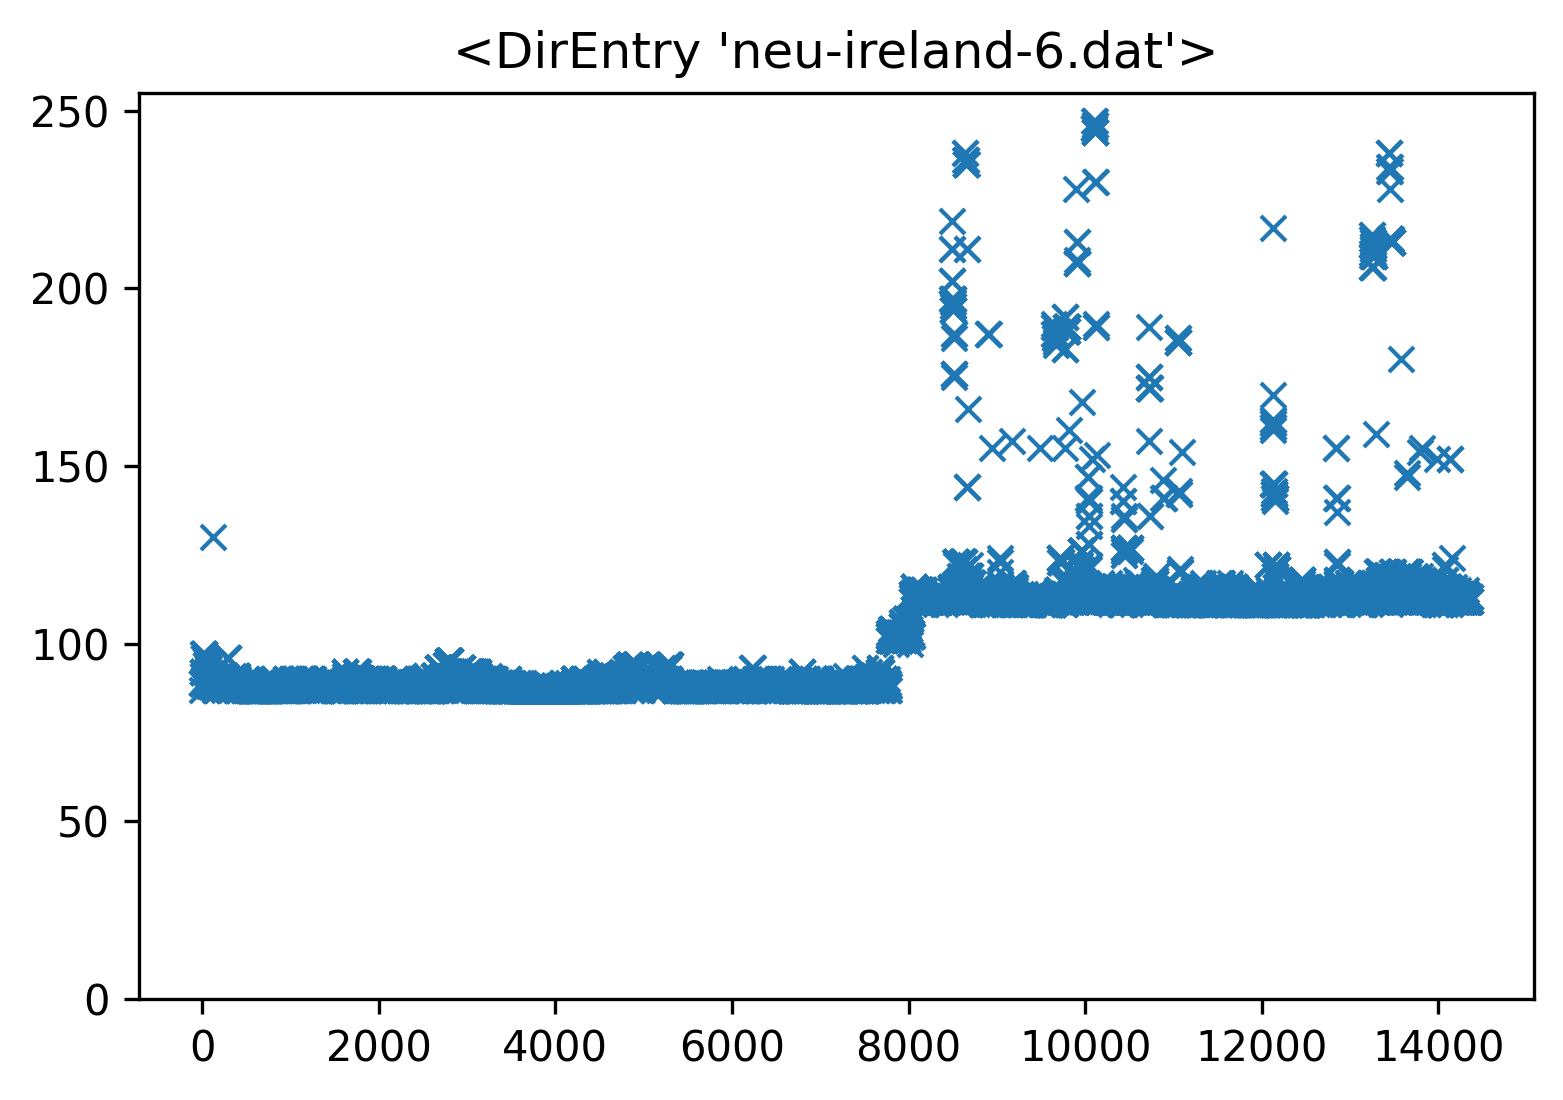

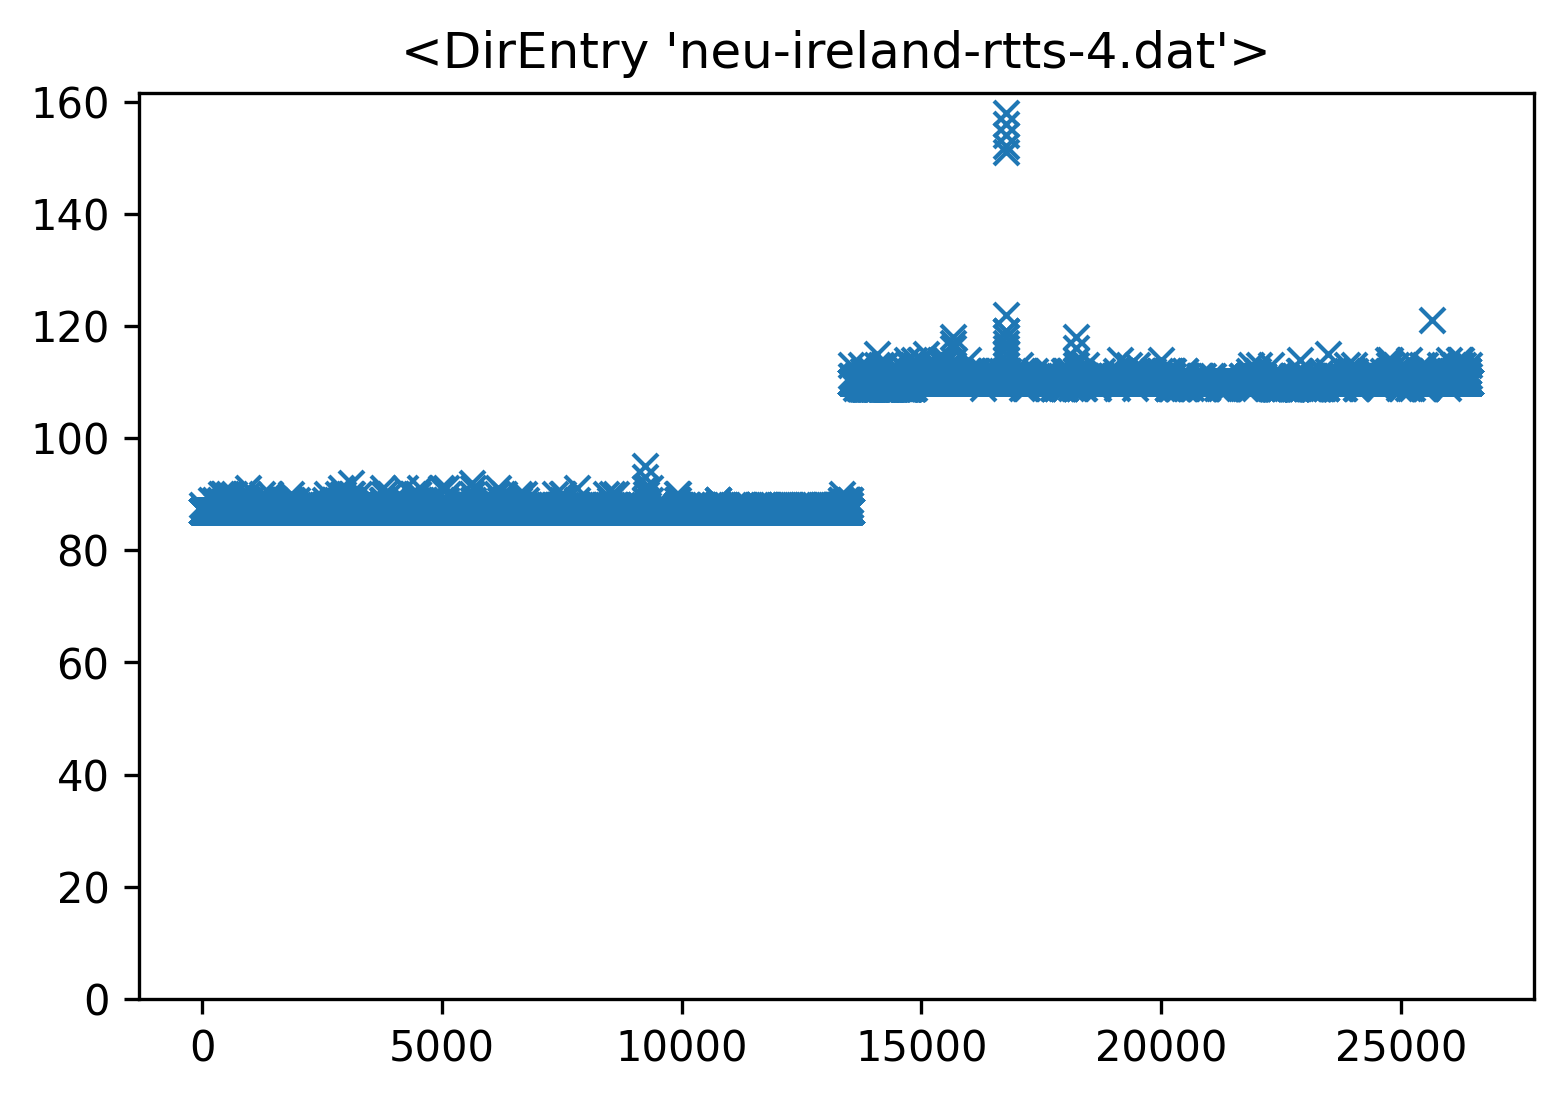

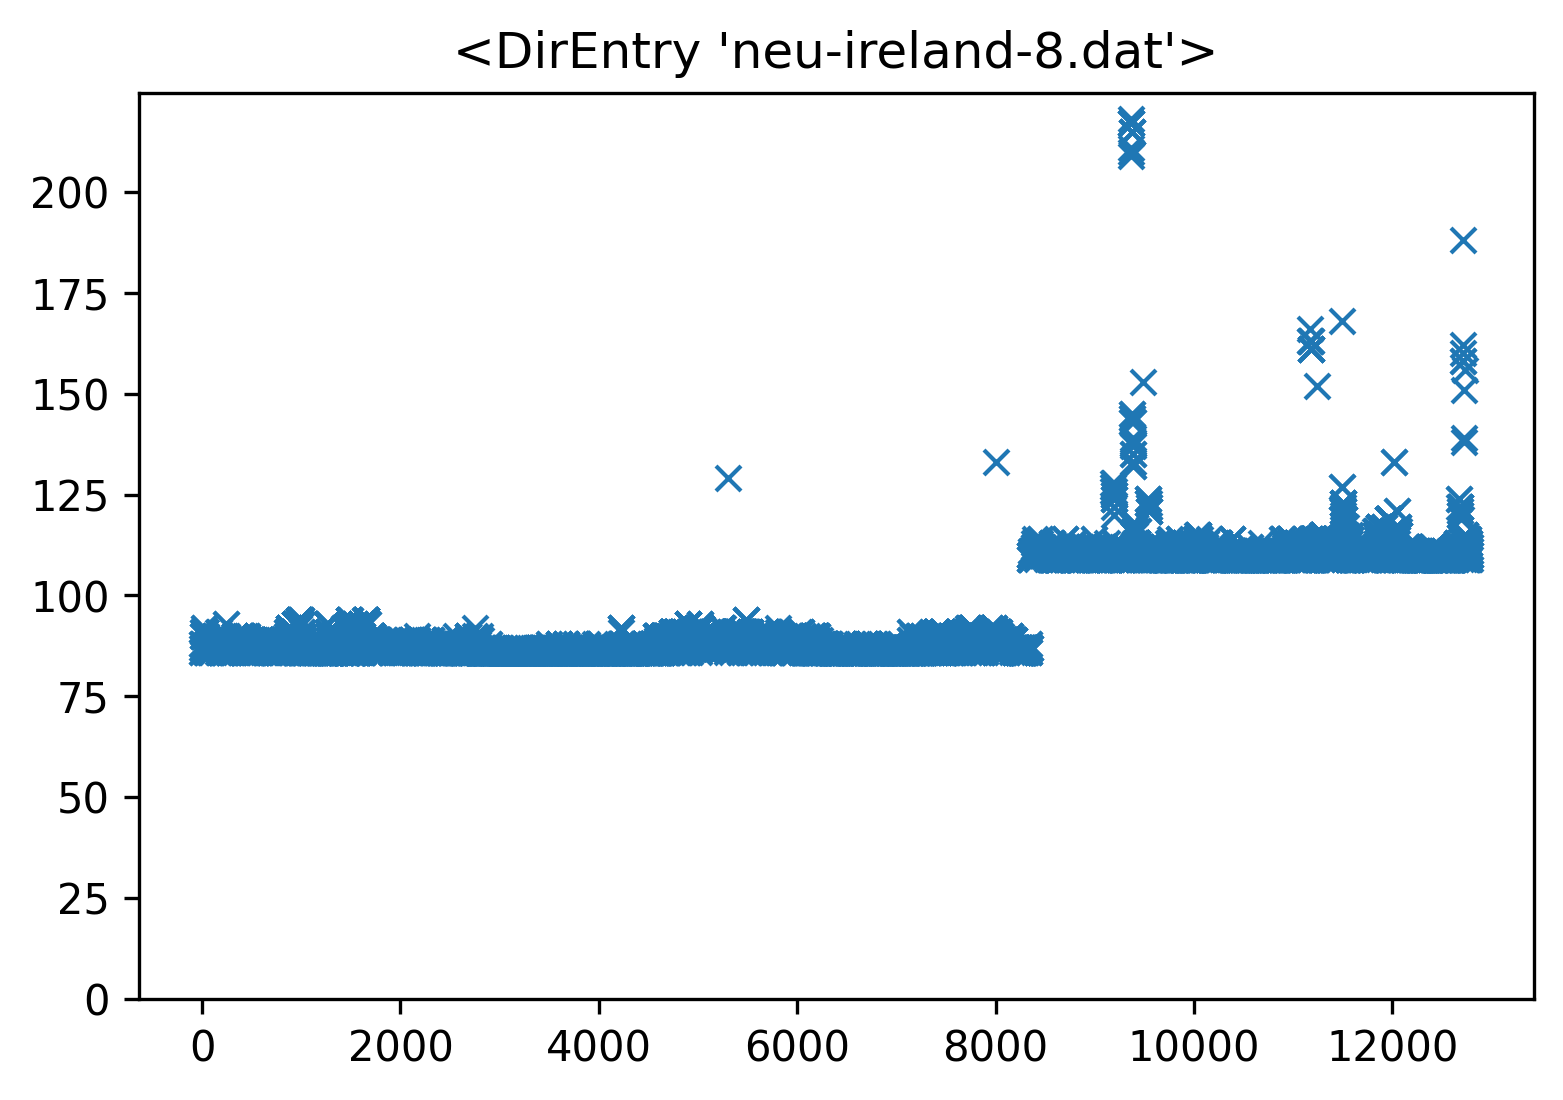

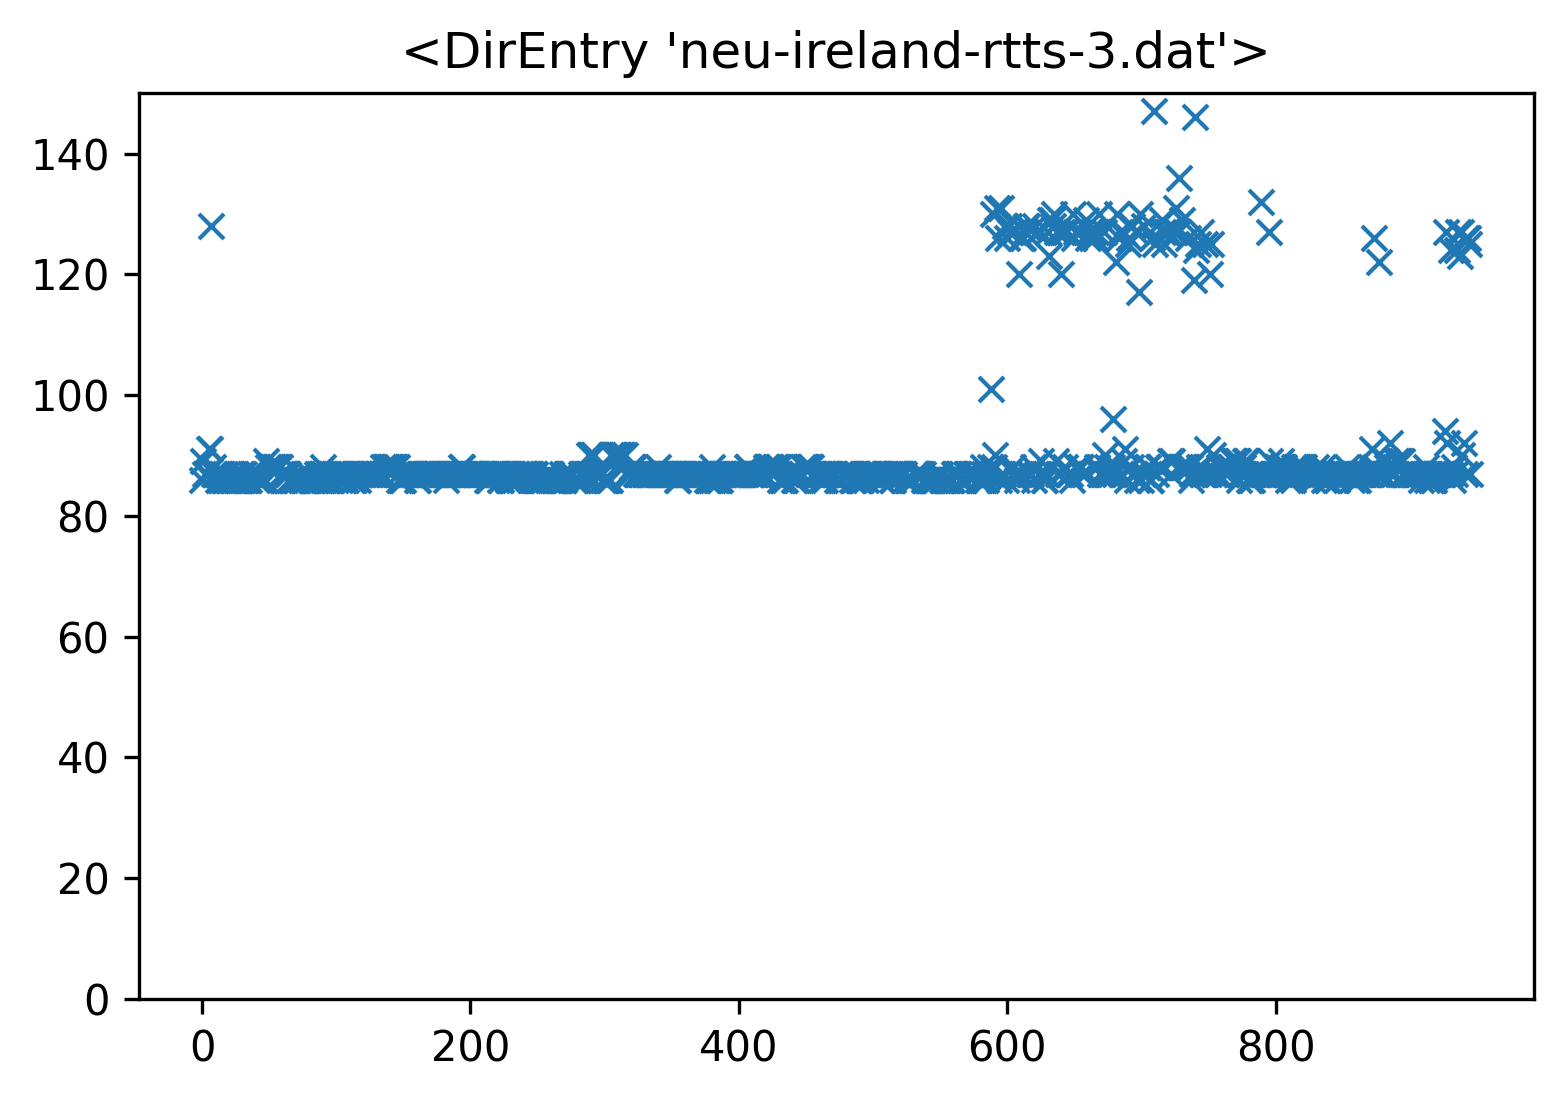

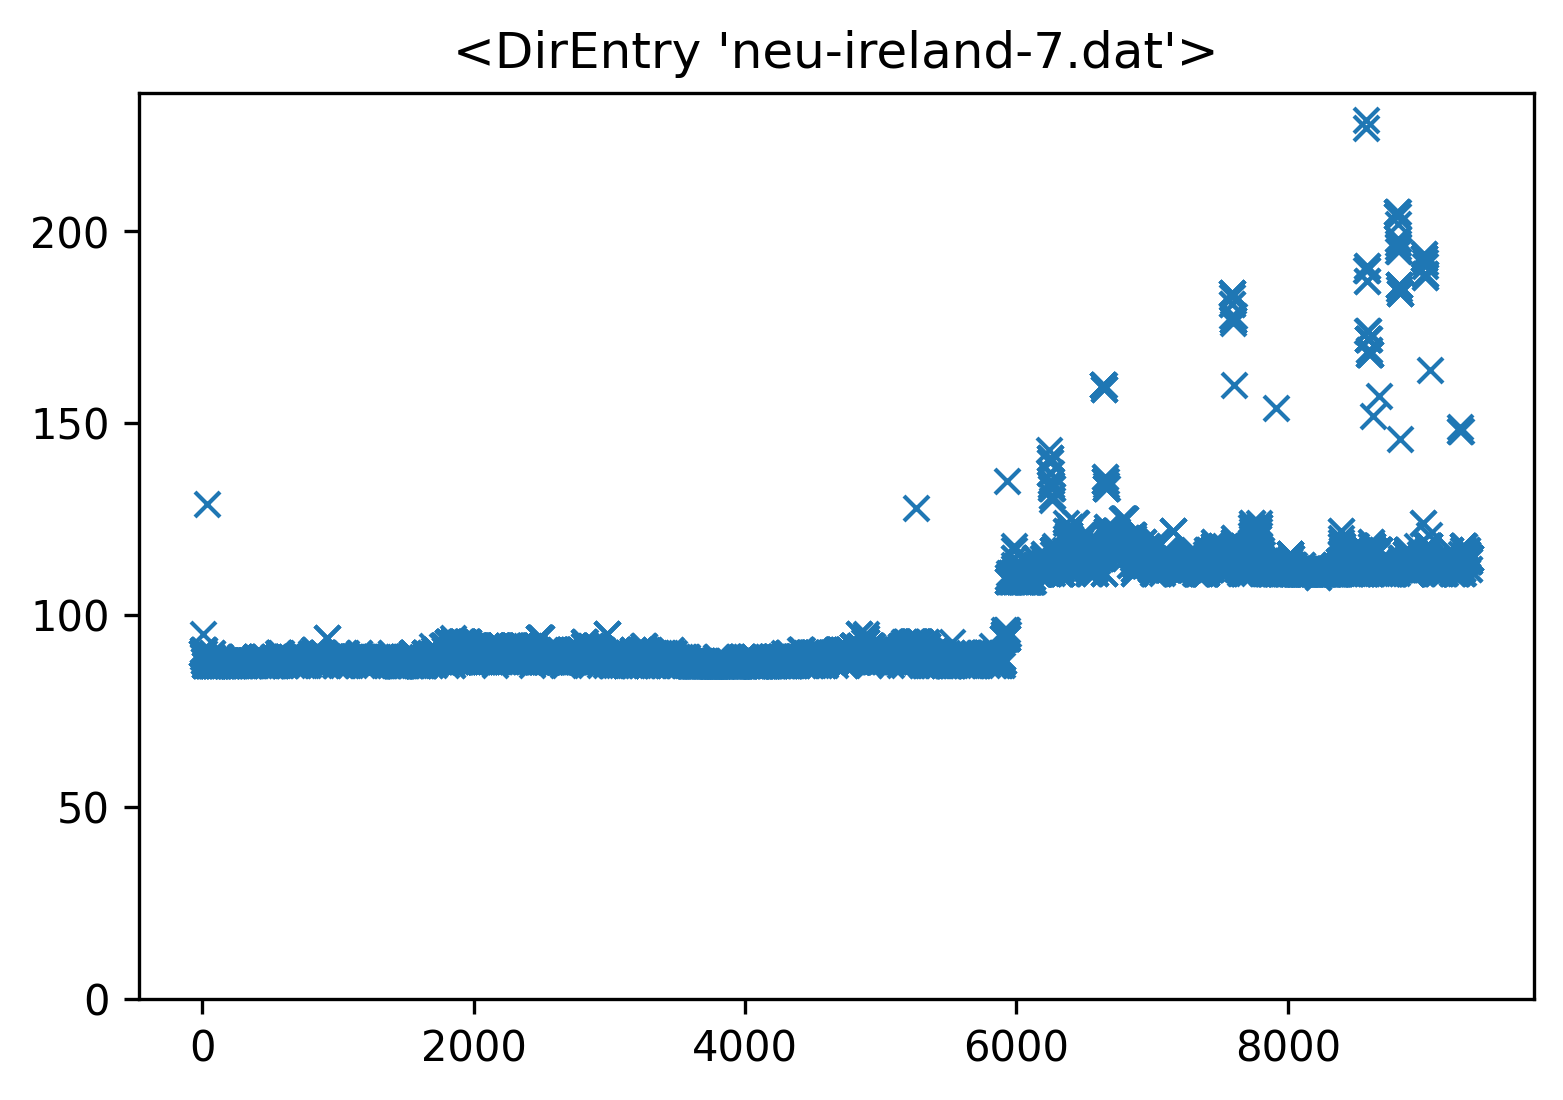

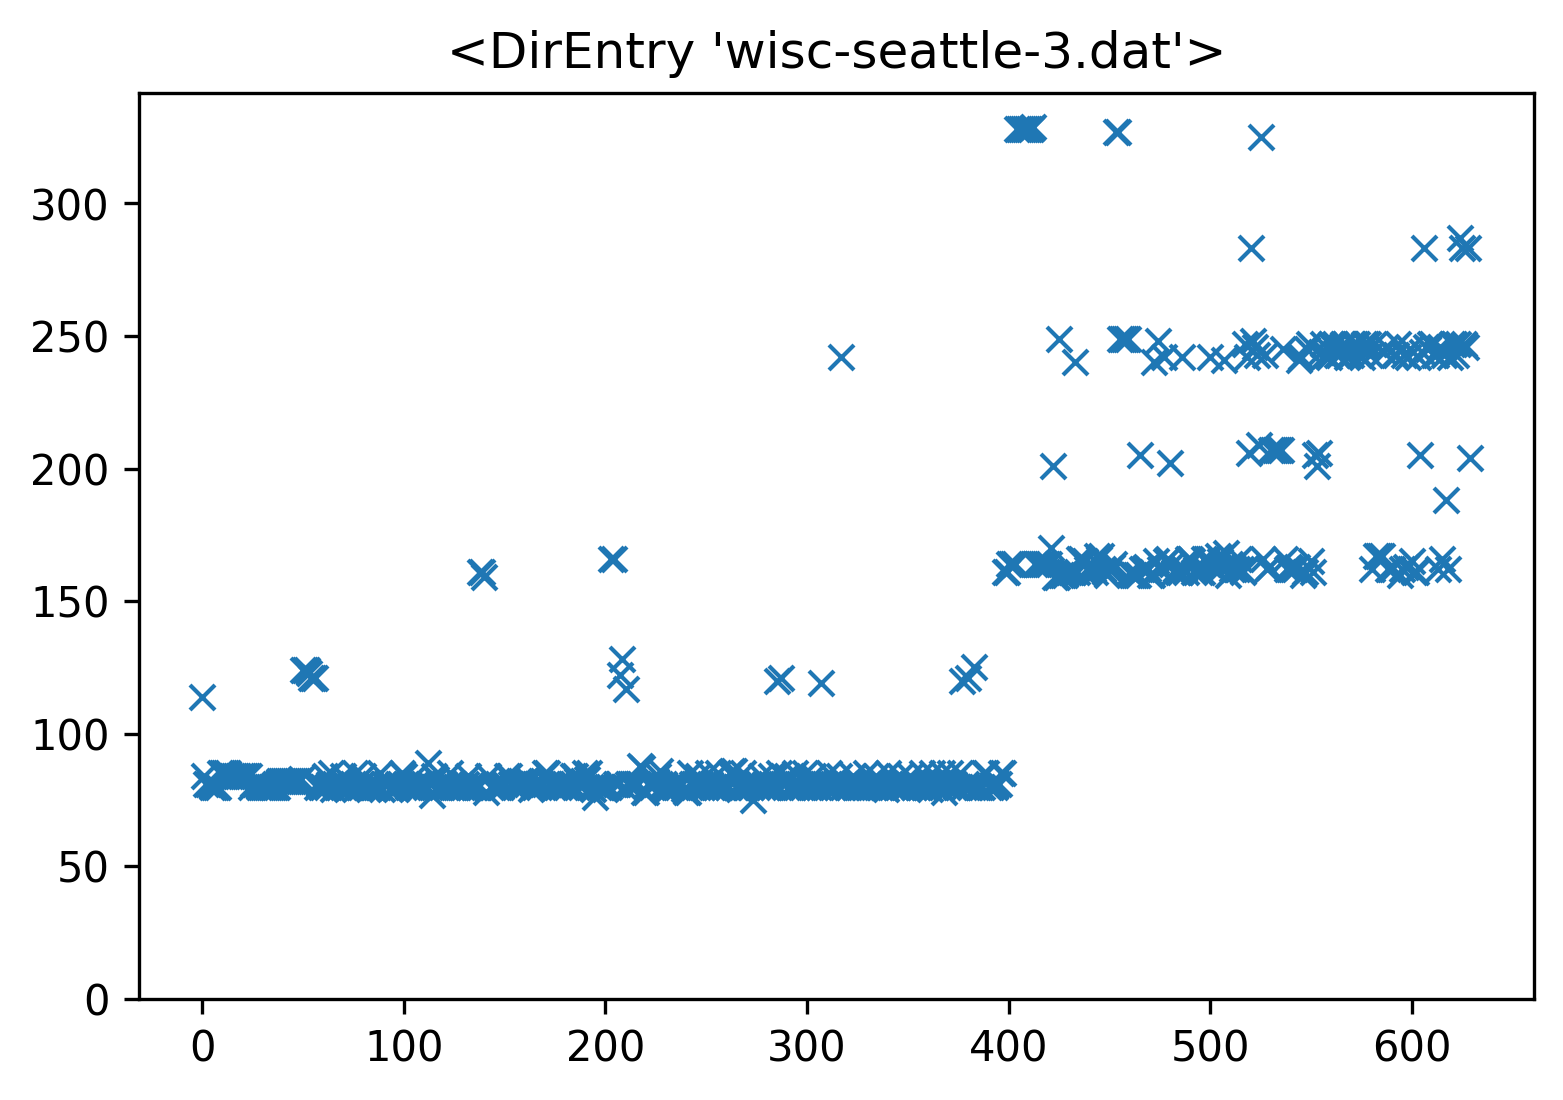

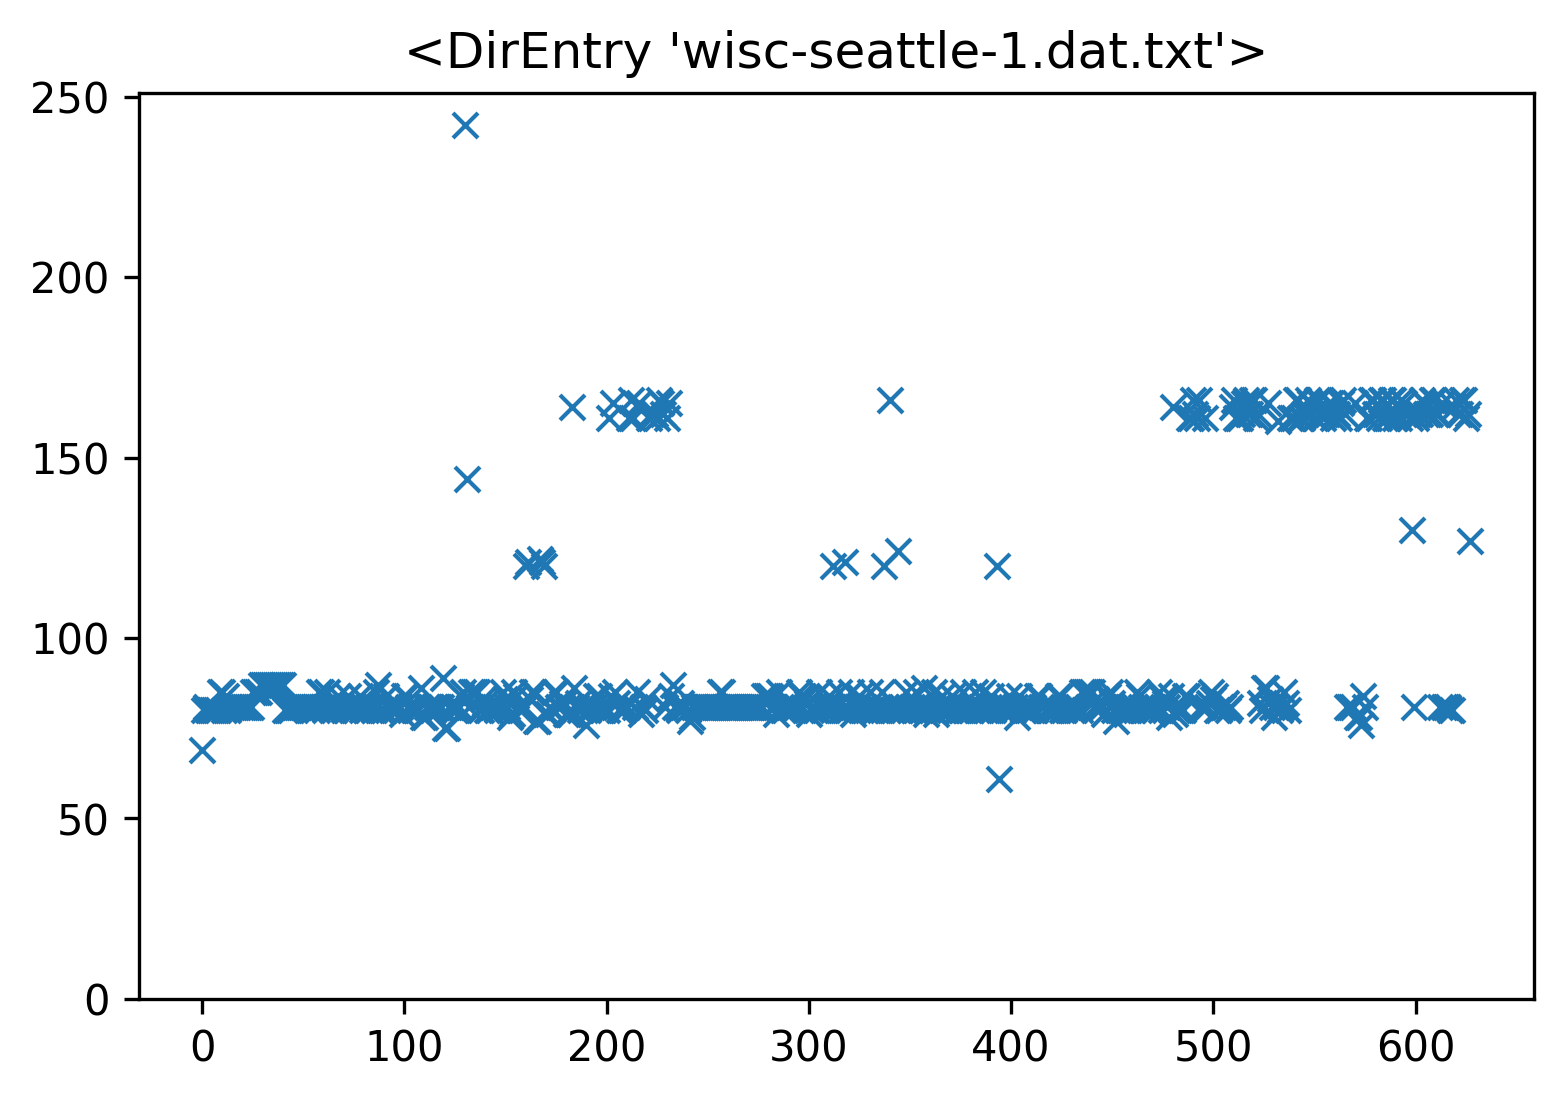

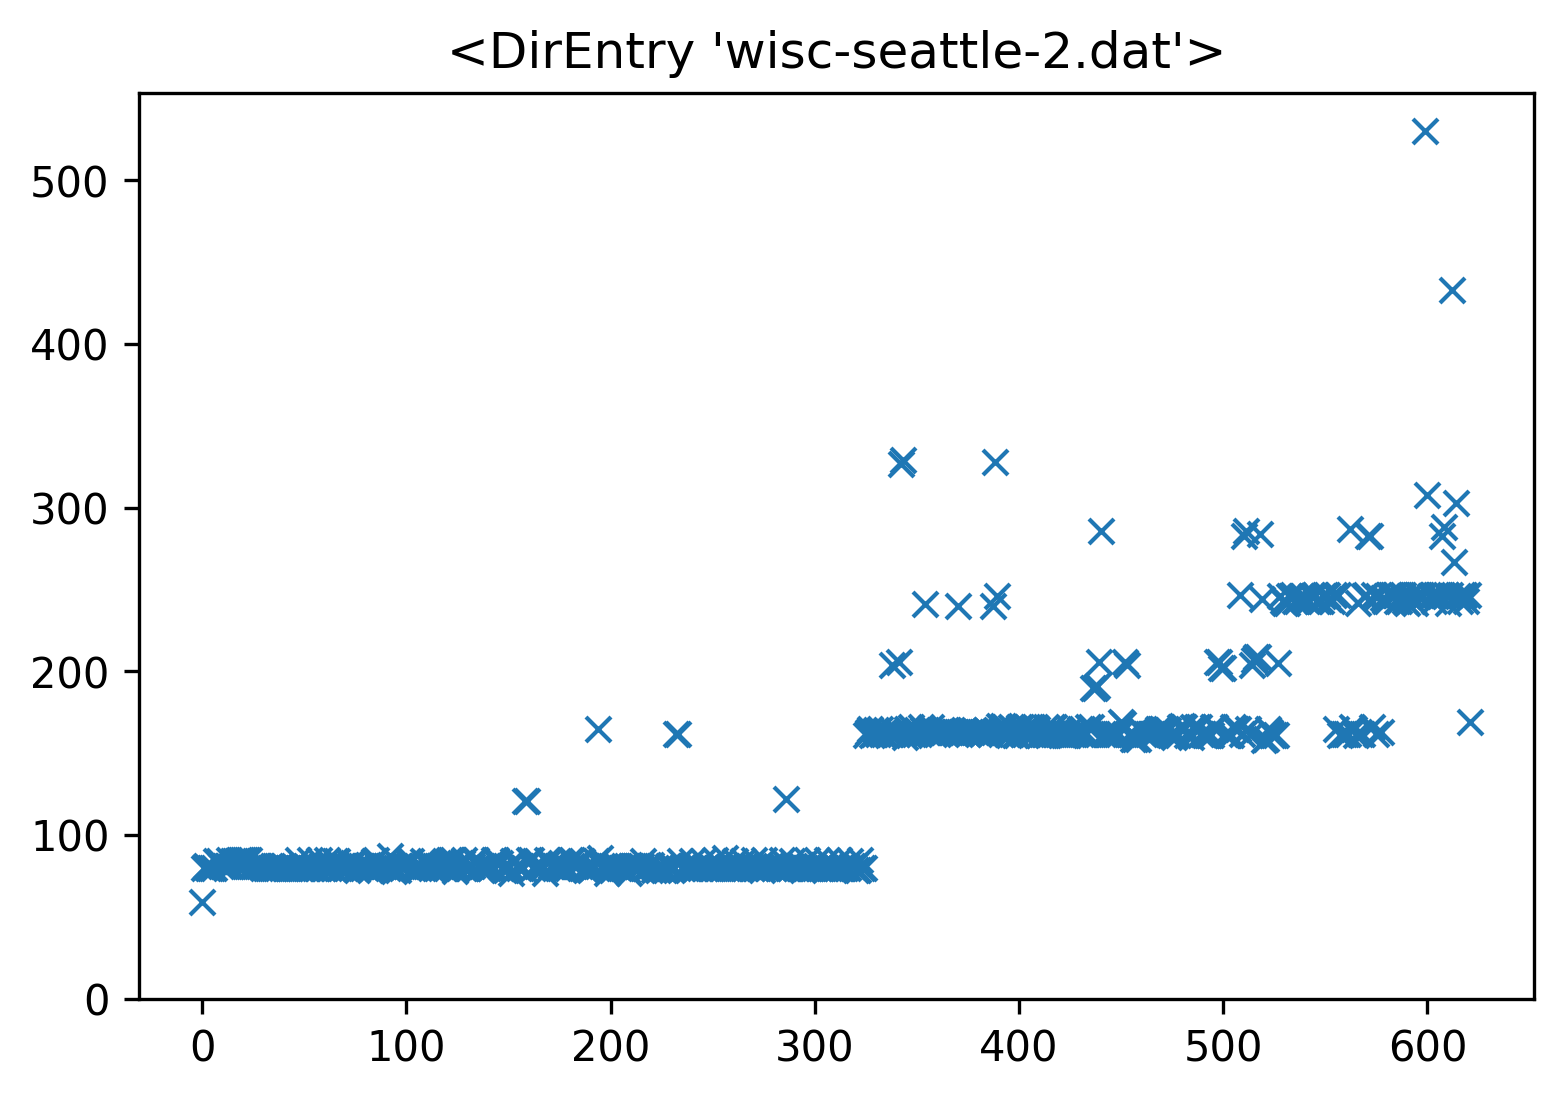

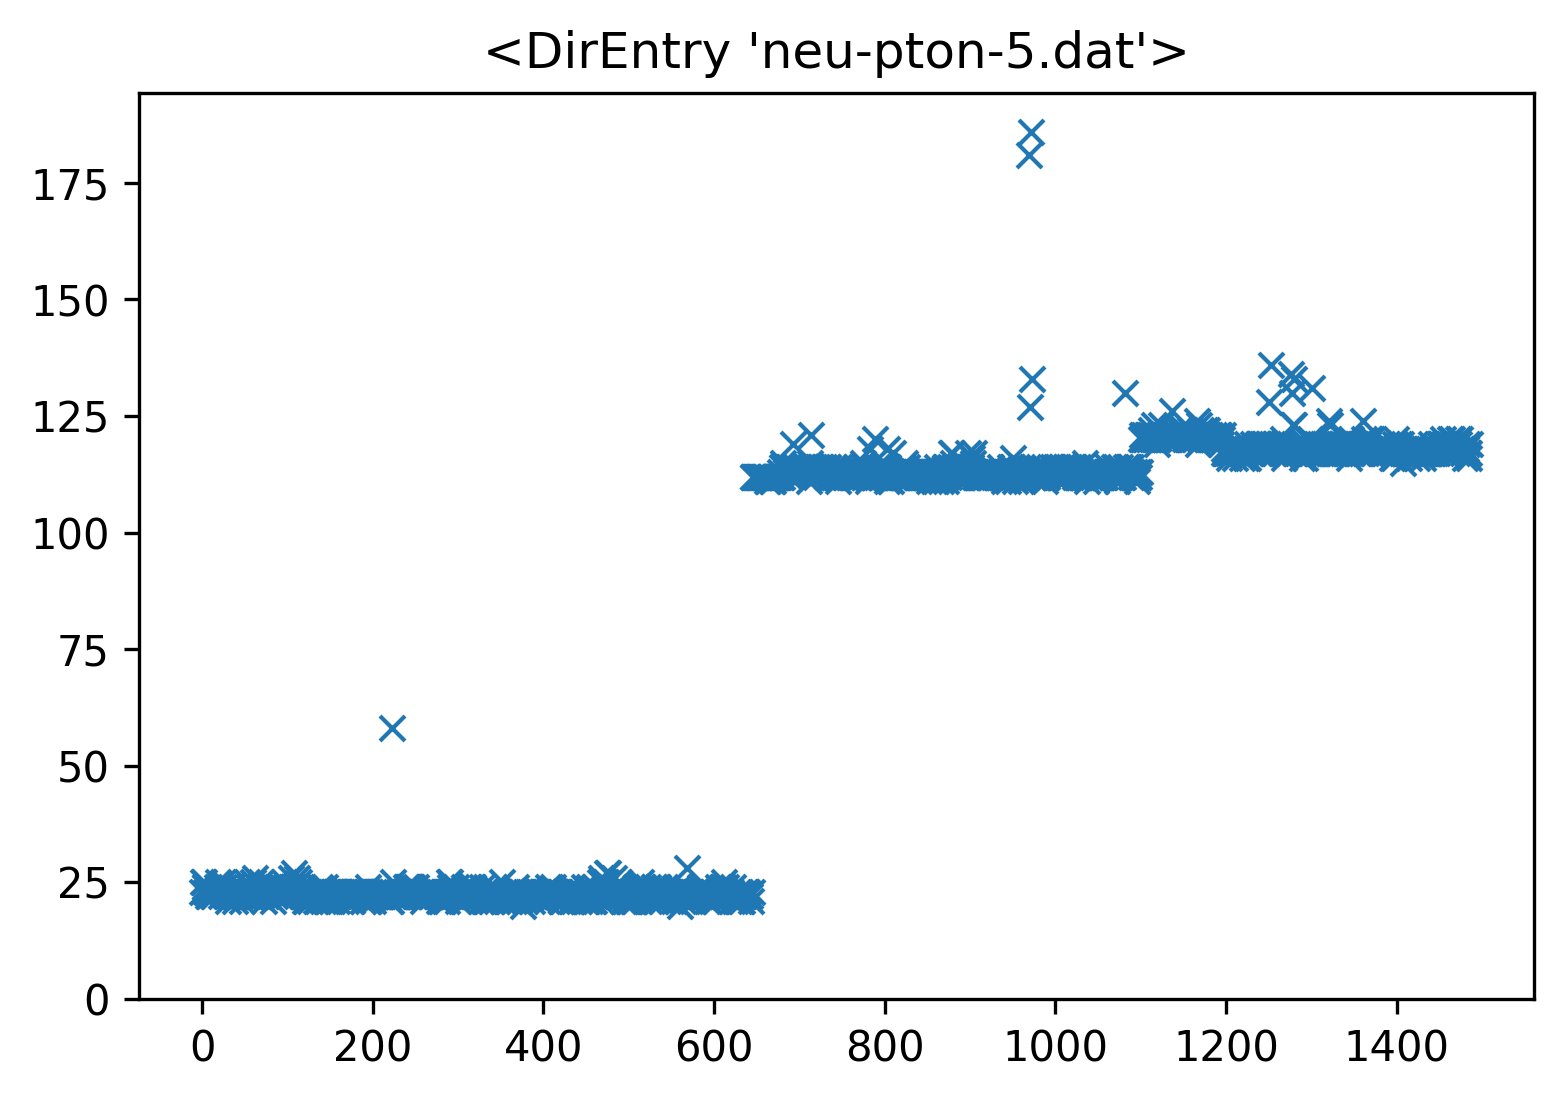

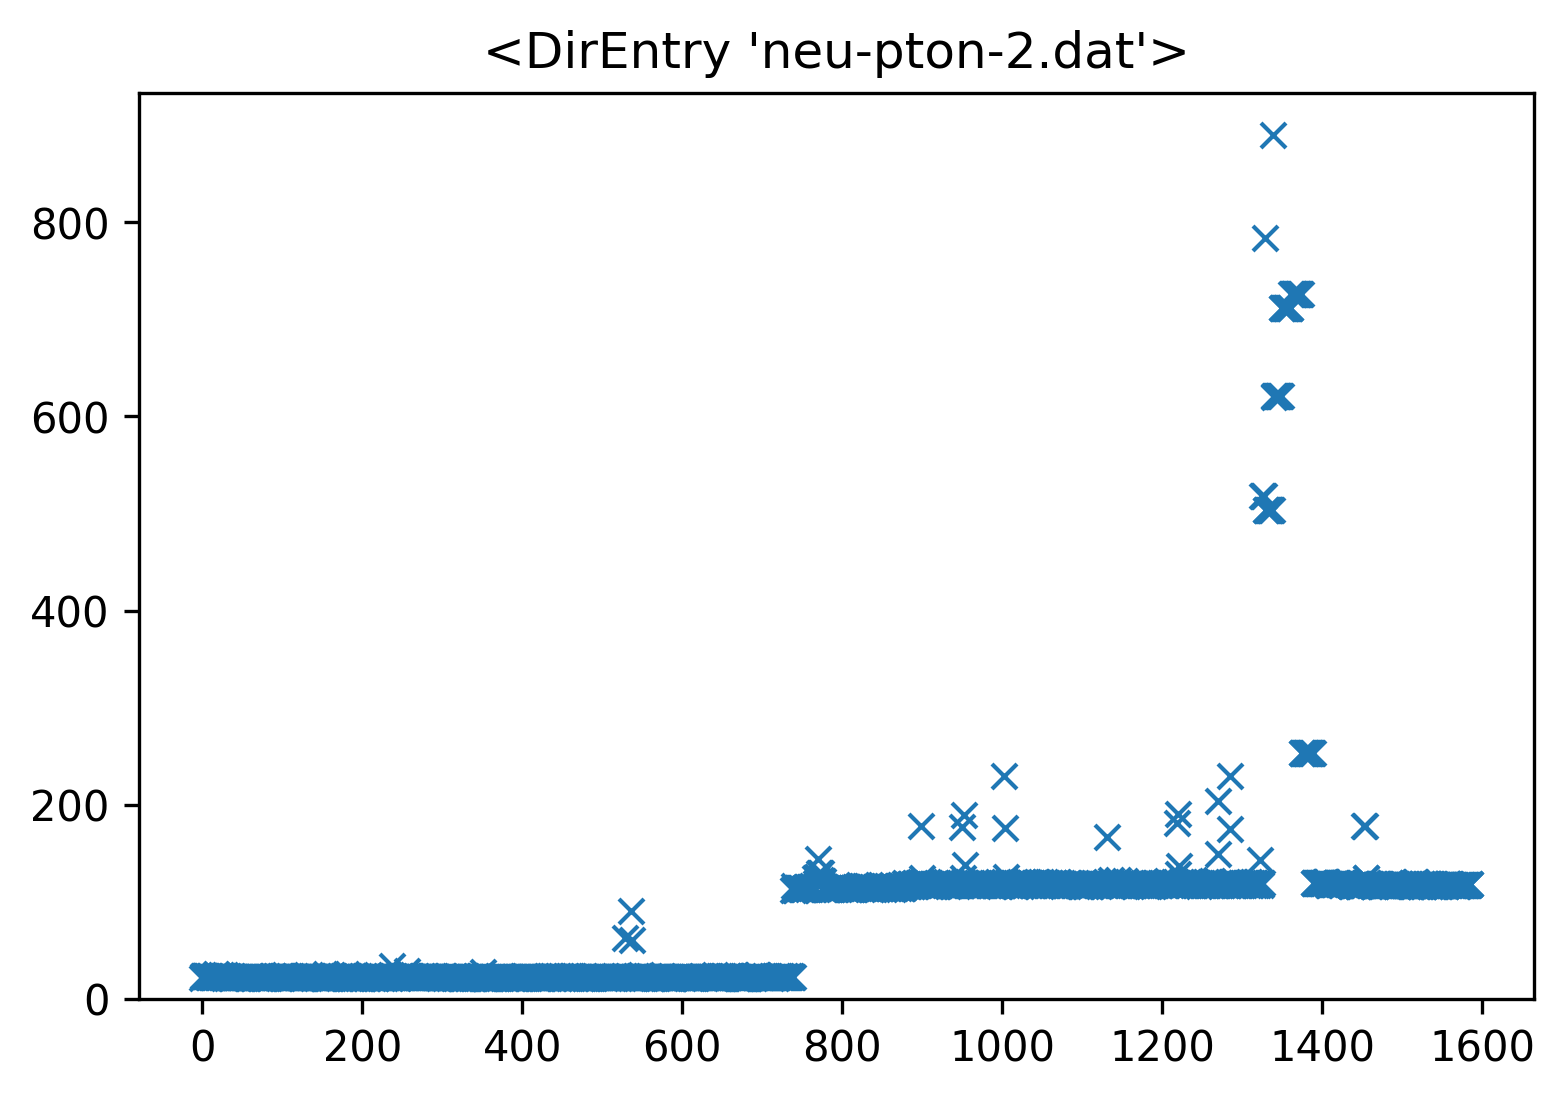

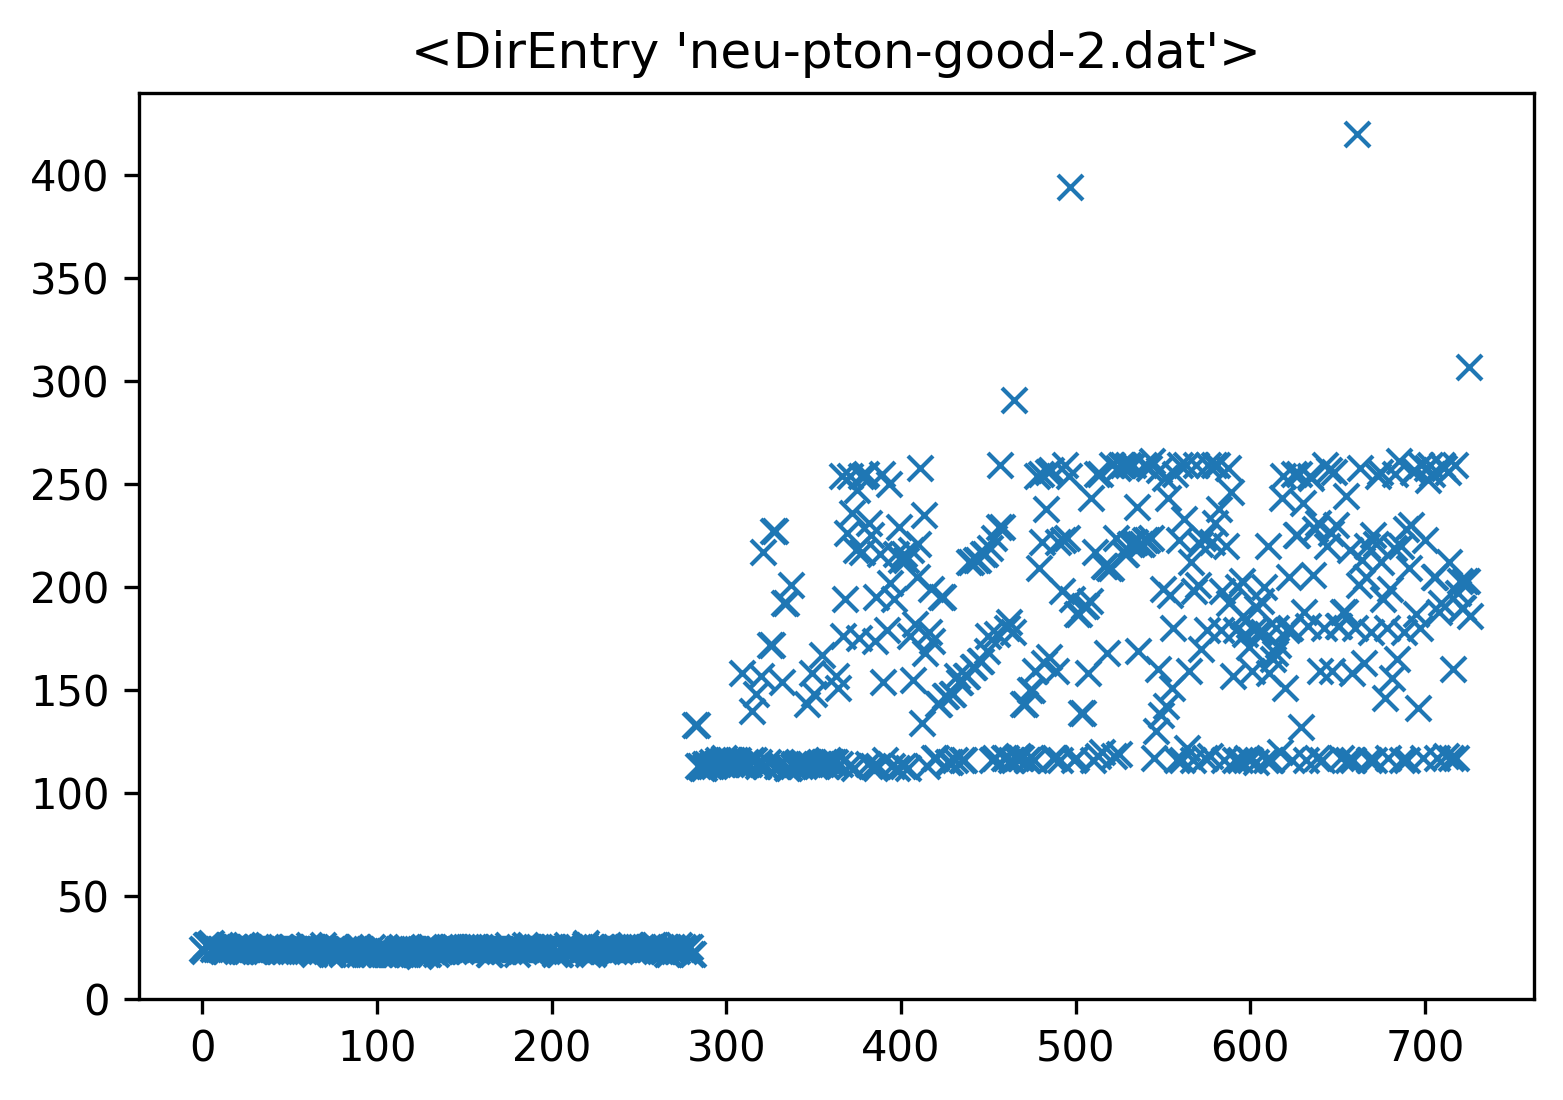

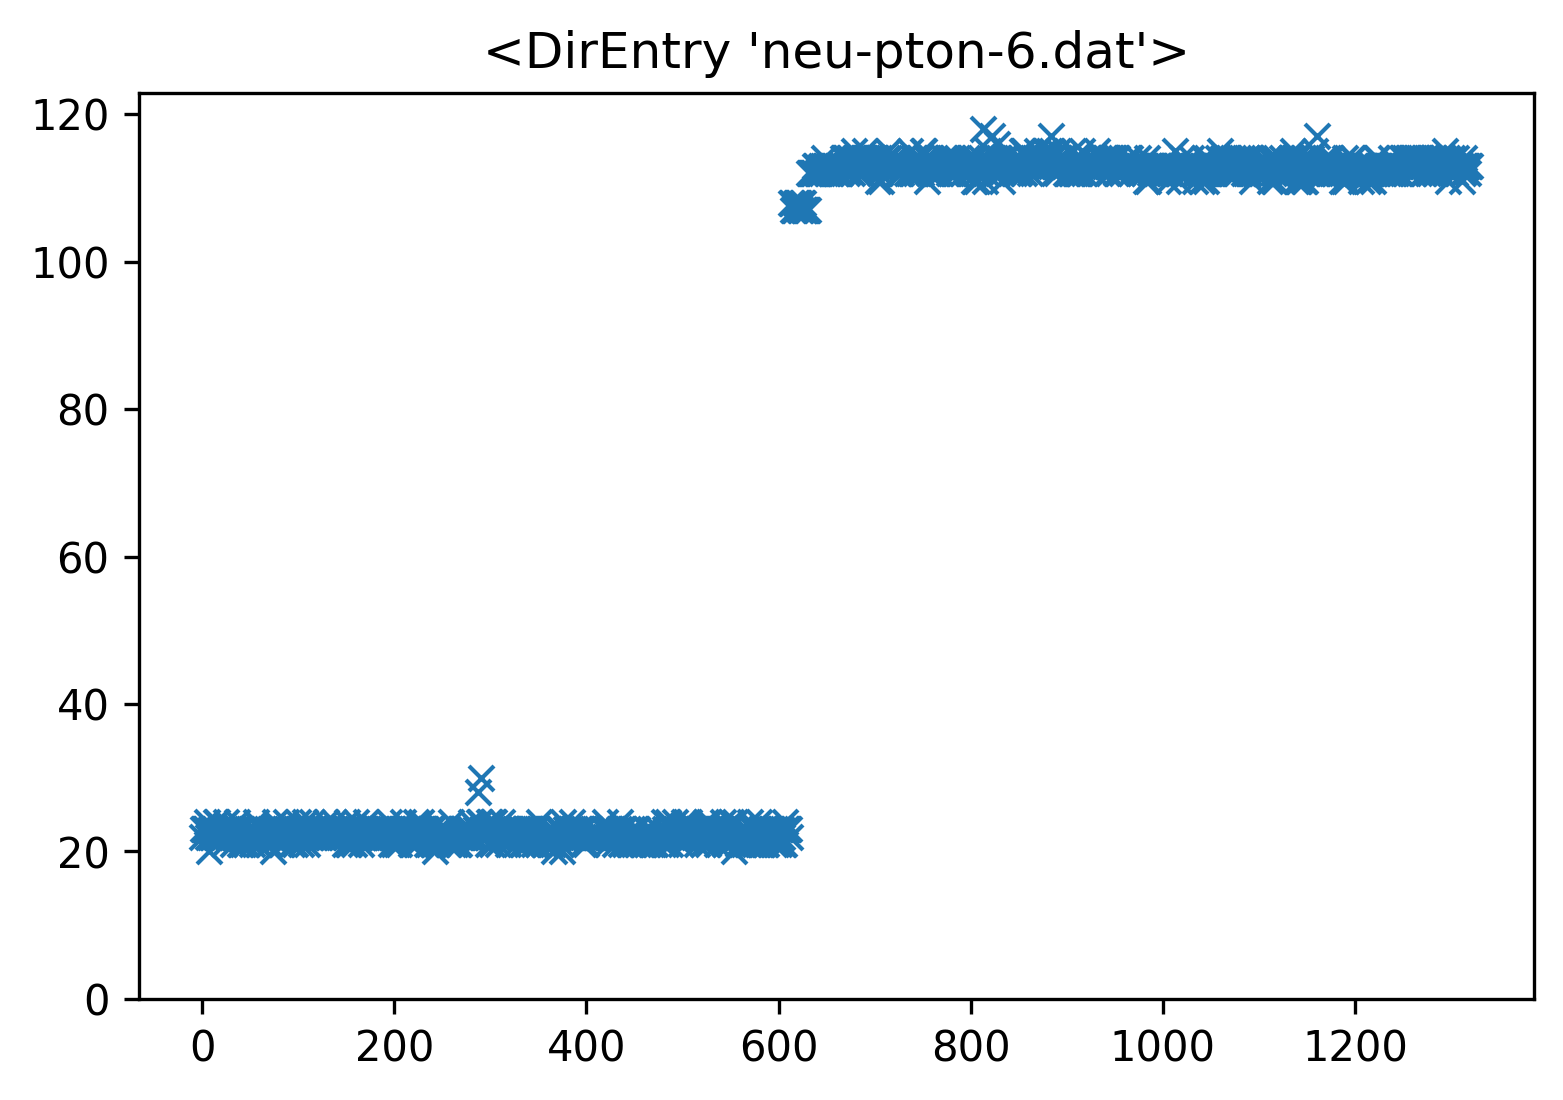

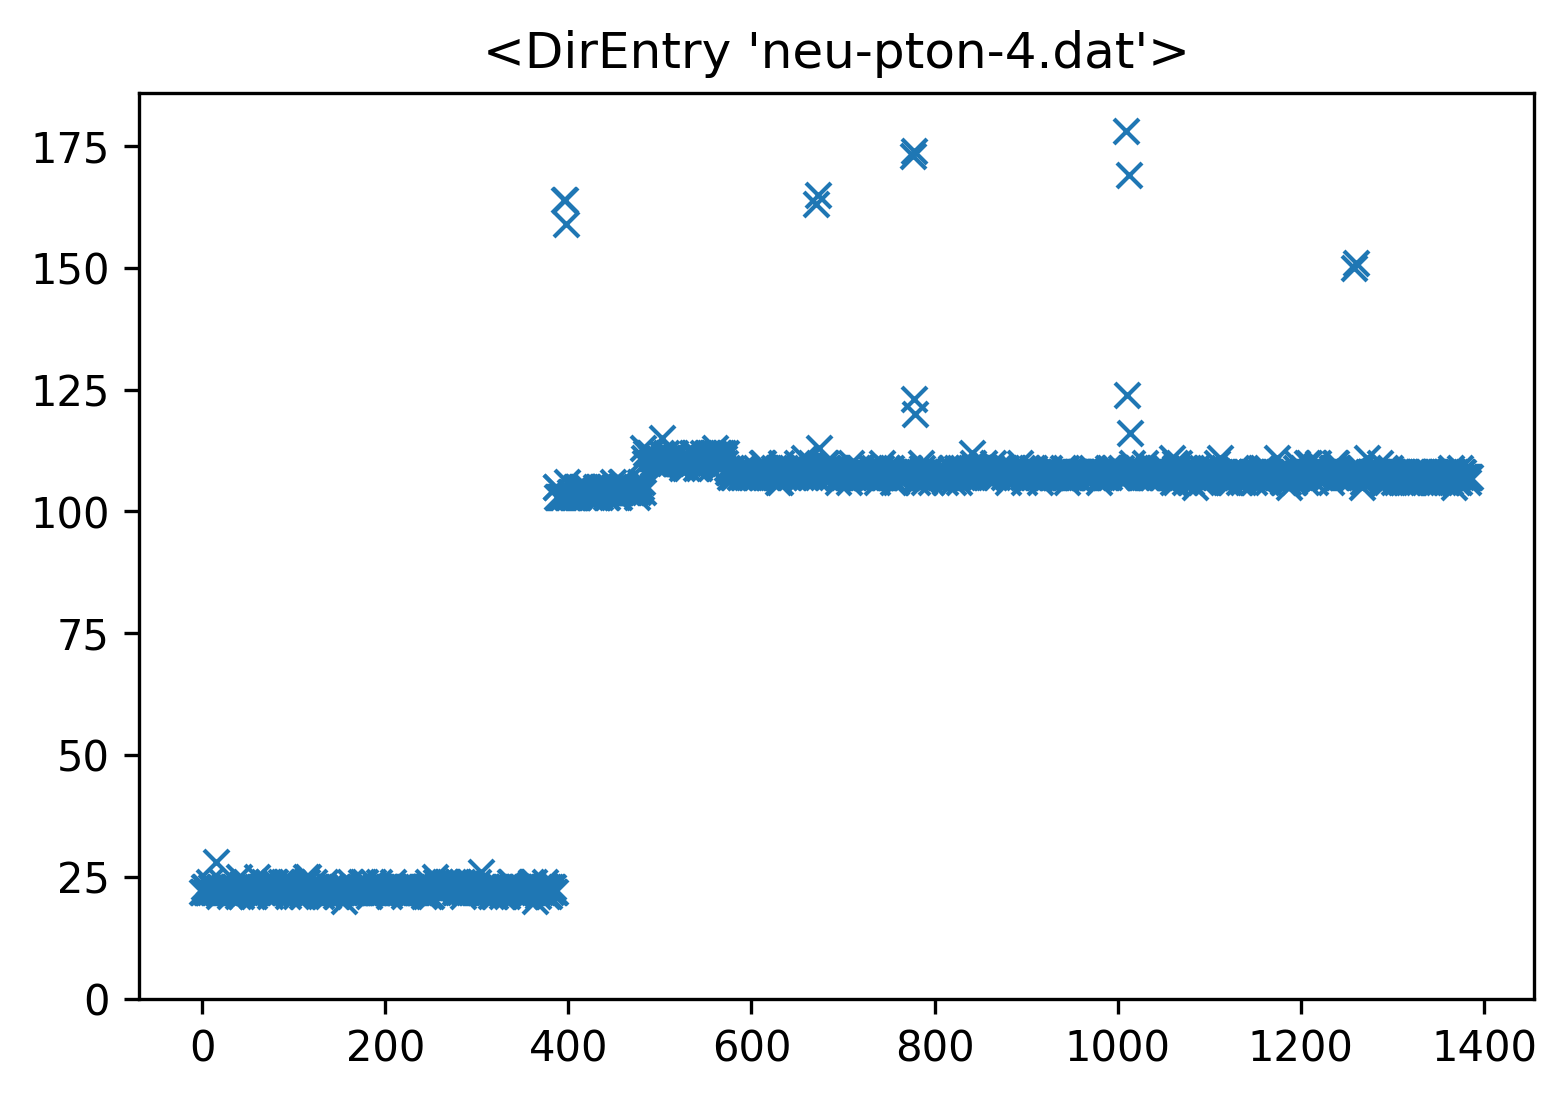

In [177]:
twoWindowRes = {}
threeWindowRes = {}
directory = './peeringrtts'
# for subdir, dirs, files in os.walk(directory):
#     print(subdir, dirs, files)
#     for dire in dirs:
#         dire = f'{directory}/{dire}'
for subdir in os.scandir(directory):
    for file in os.scandir(subdir):
        print(file)
        data = getDataFromDatFile(file)
        y = [eval(x.split(" ")[1]) for x in data]
        fig,ax = plt.subplots()
        plt.plot(y, 'x')
        plt.title(str(file))
        plt.ylim(0)
        twoWindowRes[file] = checkTwoWindow(y)
        threeWindowRes[file] = checkThreeWindow(y)


[485, 502]


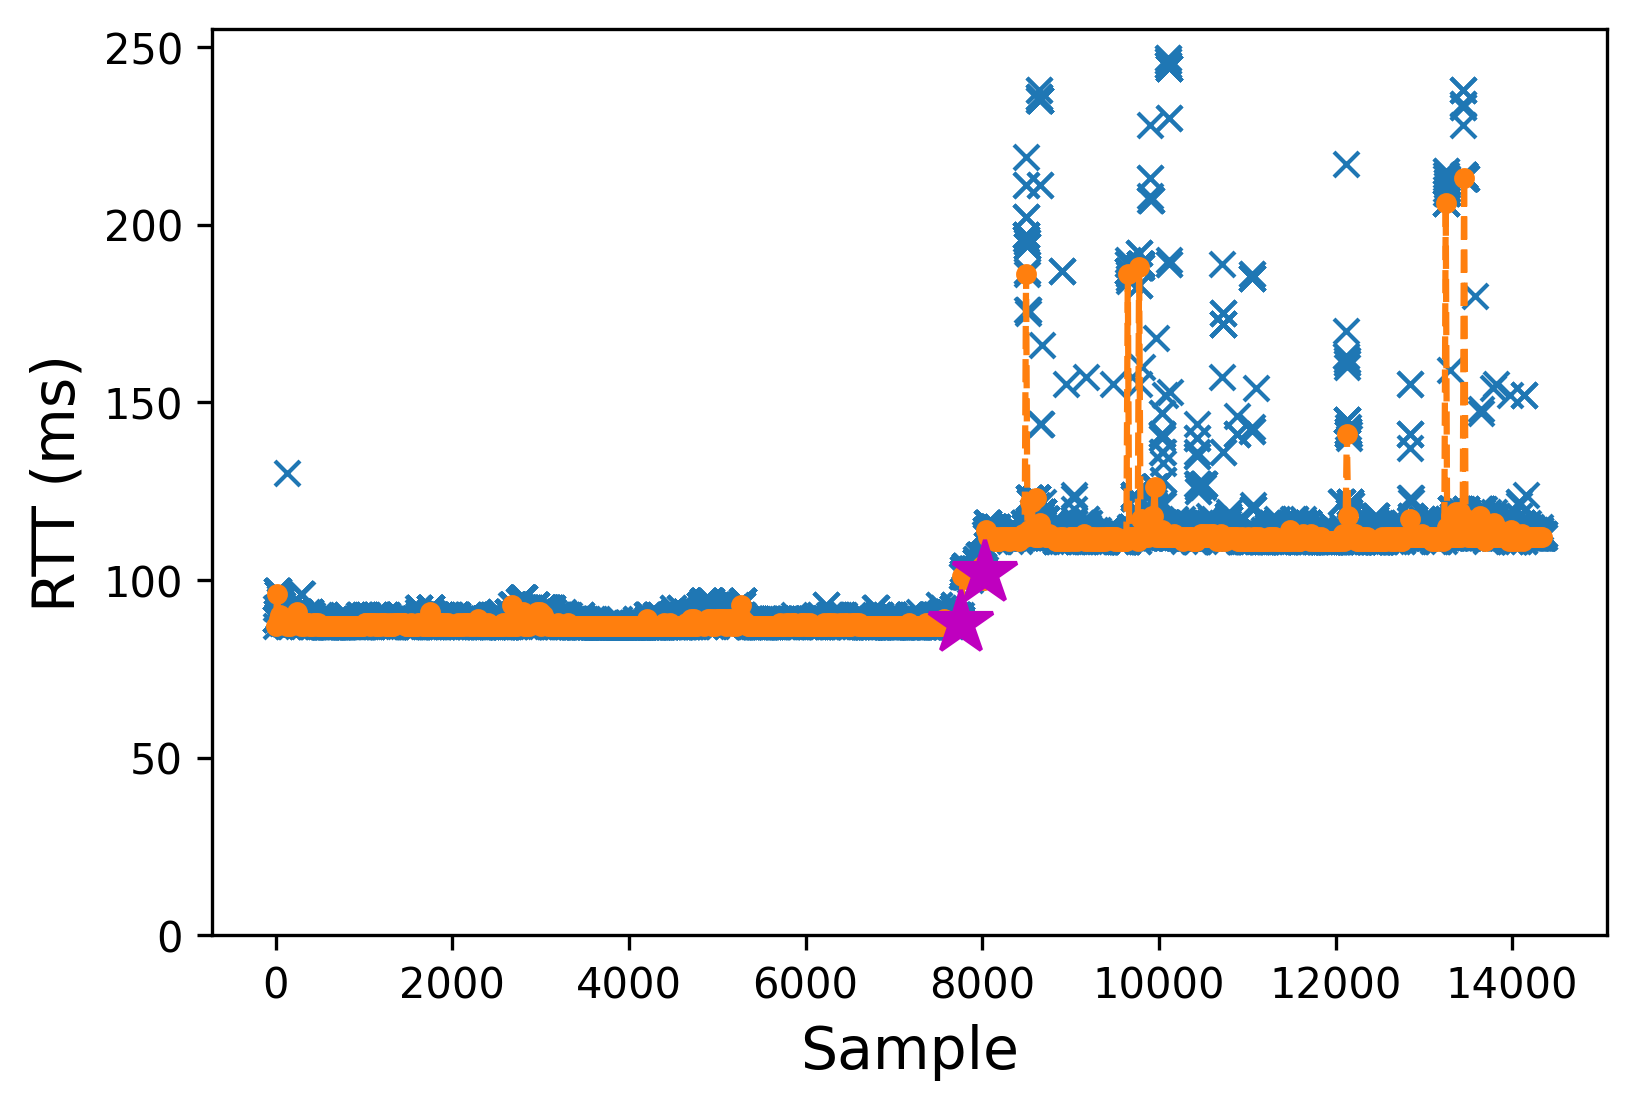

In [188]:
data = getDataFromDatFile('./peeringrtts/irelandrtts/neu-ireland-6.dat')
y = [eval(x.split(" ")[1]) for x in data]
windowSize =16
flag, mins, jumps,_ = threeWindow(y, windowSize, 10, 9)
plt.plot(y, 'x')
plt.ylabel('RTT (ms)', FontSize=14)
plt.xlabel('Sample', FontSize=14)
jumpx = [jump * windowSize for jump in jumps]
jumpy = [y[x] for x in jumpx]
minsx=[i for i in range(0, len(y)-windowSize, windowSize)]
plt.plot(minsx, mins, '.--', MarkerSize=8)
plt.plot(jumpx,jumpy, 'm*', MarkerSize=16)
plt.ylim(0)
print(jumps)
# plt.xlim(550,650)
# plt.savefig('./neu-pton-2-3w-16-75-9-415.png', bbox_inches='tight')
# print(jumps)

In [ ]:
key = list(threeWindowRes.keys())[0]
dicts = threeWindowRes[key]
keys = dicts[0] + dicts[1]


In [178]:
score = {}
for file in threeWindowRes.keys():
    dicts = threeWindowRes[file]
    good = dicts[0]
    for tup in good:
        old = score.get(tup, 0)
        score[tup] = old + 1
    

In [179]:
pp.pprint(score)

{(4, 5, 2): 12,
 (4, 5, 5): 12,
 (4, 5, 9): 12,
 (4, 10, 2): 12,
 (4, 10, 5): 12,
 (4, 10, 9): 12,
 (4, 20, 2): 12,
 (4, 20, 5): 12,
 (4, 20, 9): 12,
 (4, 30, 2): 10,
 (4, 30, 5): 10,
 (4, 30, 9): 11,
 (4, 40, 2): 10,
 (4, 40, 5): 10,
 (4, 40, 9): 11,
 (4, 50, 2): 10,
 (4, 50, 5): 10,
 (4, 50, 9): 11,
 (4, 75, 2): 10,
 (4, 75, 5): 10,
 (4, 75, 9): 11,
 (4, 100, 2): 3,
 (4, 100, 5): 3,
 (4, 100, 9): 3,
 (4, 125, 2): 3,
 (4, 125, 5): 3,
 (4, 125, 9): 3,
 (4, 200, 2): 1,
 (4, 200, 5): 1,
 (4, 200, 9): 1,
 (8, 5, 2): 12,
 (8, 5, 5): 12,
 (8, 5, 9): 12,
 (8, 10, 2): 12,
 (8, 10, 5): 12,
 (8, 10, 9): 12,
 (8, 20, 2): 11,
 (8, 20, 5): 12,
 (8, 20, 9): 12,
 (8, 30, 2): 9,
 (8, 30, 5): 10,
 (8, 30, 9): 11,
 (8, 40, 2): 9,
 (8, 40, 5): 10,
 (8, 40, 9): 10,
 (8, 50, 2): 9,
 (8, 50, 5): 10,
 (8, 50, 9): 10,
 (8, 75, 2): 9,
 (8, 75, 5): 9,
 (8, 75, 9): 9,
 (8, 100, 2): 2,
 (8, 100, 5): 2,
 (8, 100, 9): 2,
 (8, 125, 2): 1,
 (8, 125, 5): 1,
 (8, 125, 9): 1,
 (8, 200, 2): 1,
 (8, 200, 5): 1,
 (8, 200,

[[(8, 10),
  (8, 20),
  (8, 30),
  (8, 40),
  (8, 50),
  (8, 75),
  (16, 10),
  (16, 20),
  (16, 30),
  (16, 40),
  (16, 50),
  (16, 75),
  (24, 10),
  (24, 20),
  (24, 30),
  (24, 40),
  (24, 50),
  (24, 75),
  (48, 5),
  (48, 10),
  (48, 20),
  (48, 30),
  (48, 40),
  (48, 50),
  (48, 75)],
 [(8, 5),
  (8, 100),
  (8, 125),
  (8, 200),
  (16, 5),
  (16, 100),
  (16, 125),
  (16, 200),
  (24, 5),
  (24, 100),
  (24, 125),
  (24, 200),
  (48, 100),
  (48, 125),
  (48, 200)]]
[[(8, 10, 2),
  (8, 10, 9),
  (8, 20, 2),
  (8, 20, 9),
  (8, 30, 2),
  (8, 30, 9),
  (8, 40, 2),
  (8, 40, 9),
  (8, 50, 2),
  (8, 50, 9),
  (8, 75, 2),
  (8, 75, 9),
  (16, 10, 2),
  (16, 10, 9),
  (16, 20, 2),
  (16, 20, 9),
  (16, 30, 2),
  (16, 30, 9),
  (16, 40, 2),
  (16, 40, 9),
  (16, 50, 2),
  (16, 50, 9),
  (16, 75, 2),
  (16, 75, 9),
  (24, 10, 2),
  (24, 10, 9),
  (24, 20, 2),
  (24, 20, 9),
  (24, 30, 2),
  (24, 30, 9),
  (24, 40, 2),
  (24, 40, 9),
  (24, 50, 2),
  (24, 50, 9),
  (24, 75, 2),
  (24, 

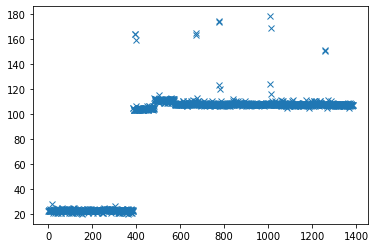

In [65]:
filename = './peeringrtts/rtts/neu-pton-4.dat'
pp.pprint(twoWindowRes[filename])
pp.pprint(threeWindowRes[filename])
data = getDataFromDatFile(filename)
y = [eval(x.split(" ")[1]) for x in data]
plt.plot(y, 'x')

In [28]:
print(count, badCount)

32 8


In [49]:
print(goodParameters)

[(4, 20, 2), (4, 20, 9), (8, 20, 2), (8, 20, 9), (16, 20, 2), (16, 20, 9), (24, 20, 2), (24, 20, 9), (48, 20, 2), (48, 20, 9)]
